In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import imdb
from keras.preprocessing import sequence
from IPython.display import display, Markdown

%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras import models
from keras import optimizers as opt
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from attention.layers import AttentionLayer

# Please notice that this dataset is quite simple, so it's easy to overfit a model on it.
# We are using it because it comes bundled with Keras and the goal is to showcase the layer only

In [3]:
VOCAB_SIZE = 10000
MAX_LEN = 100
HIDDEN_SIZE = 16
DROPOUT = 0.5

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

x_train = sequence.pad_sequences(x_train, MAX_LEN, padding='post', truncating='post')
x_test = sequence.pad_sequences(x_test, MAX_LEN, padding='post', truncating='post')

In [4]:
def build_model():
    sentence_in = Input((MAX_LEN, ),
                        name='sentence-in')

    embedded = Embedding(VOCAB_SIZE,
                         HIDDEN_SIZE,
                         mask_zero=True,
                         name='embedding')(sentence_in)

    vectors  = LSTM(HIDDEN_SIZE,
                    return_sequences=True,
                    dropout=DROPOUT,
                    recurrent_dropout=DROPOUT,
                    name='ff-lstm')(embedded)

    sentence = AttentionLayer(name='attention')(vectors)

    output   = Dense(1,
                     activation='sigmoid',
                     name='output')(sentence)

    model = models.Model(inputs=[sentence_in], outputs=[output])
    return model

In [5]:
# (b, t, d)
model = build_model()
model.summary()
    
model.compile('adam', 'binary_crossentropy', metrics=['binary_accuracy'])
model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence-in (InputLayer)     (None, 100)               0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
ff-lstm (LSTM)               (None, 100, 16)           2112      
_________________________________________________________________
attention (AttentionLayer)   (None, 16)                288       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 162,417
Trainable params: 162,417
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 110s 6ms/step - loss: 0.5982 -

In [6]:
def build_viz_model(trained_model):
    """Architecture: input -> embedding -> lstm -> attention -> sigmoid"""
    sentence_in = Input((MAX_LEN, ),
                        name='sentence-in')

    embedded = Embedding(VOCAB_SIZE,
                         HIDDEN_SIZE,
                         mask_zero=True,
                         weights=trained_model.layers[1].get_weights(),
                         name='embedding')(sentence_in)

    vectors  = LSTM(HIDDEN_SIZE,
                    return_sequences=True,
                    dropout=DROPOUT,
                    recurrent_dropout=DROPOUT,
                    weights=trained_model.layers[2].get_weights(),
                    name='ff-lstm')(embedded)

    alphas  = AttentionLayer(weights=trained_model.layers[3].get_weights(),
                              return_attention=True,
                              name='attention')(vectors)

    model = models.Model(inputs=[sentence_in], outputs=[alphas])
    return model

In [7]:
def get_index2word():
    """Computes the table that maps ids to their words."""
    INDEX_FROM = 3   # word index offset

    word2index = imdb.get_word_index()
    index2word = {v + INDEX_FROM: k for k, v in word2index.items()}
    index2word[0] = '[PAD]'
    index2word[1] = '[START]'
    index2word[2] = '[UNK]'

    return index2word


def reconstruct(sample, index2word):
    """Given a list of word ids, returns a list of words."""
    return [index2word[word] for word in sample]

In [8]:
def _weight2color(brightness):
    """Converts a single (positive) attention weight to a shade of blue."""
    brightness = brightness.item()

    brightness = int(round(255 * brightness)) # convert from 0.0-1.0 to 0-255
    ints = (255 - brightness, 255 - brightness, 255)
    return 'rgba({}, {}, {}, 0.6)'.format(*ints)


def print_sentence(label, predicted, sentence, weights):
    """Prints a sample (sequence) making the most attended words background darker."""

    parts = list()
    parts.append('<span style="padding:2px;">[actual: %10s >< pred: %10s]</span> ' % (label, predicted))
    for word, weight in zip(sentence, weights):
        if word == '[PAD]':
            break
        parts.append('<span style="background: {}; color:#000; padding:2px; font-weight=\'bold\'">{}</span>'.format(_weight2color(weight), word))
    
    text = ' '.join(parts)
    display(Markdown(text))


def plot_sentence(words, weights):
    words = [f'{i}_{word}' for i, word in enumerate(words)]
    
    plt.figure(figsize=(20, 2))
    plt.plot(words, z)
    plt.xticks(rotation=90)
    plt.grid(alpha=0.4)
    plt.ylabel('Attention')
    plt.show()

In [9]:
index2word = get_index2word()
index2label = {
    0: 'negative',
    1: 'positive'
}

viz_model = build_viz_model(model)

<span style="padding:2px;">[actual:   negative >< pred:   negative]</span>  <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[START]</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">please</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">give</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">one</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">miss</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">rest</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">cast</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">rendered</span> <span style="background: rgba(0, 0, 255, 0.6); color:#000; padding:2px; font-weight='bold'">terrible</span> <span style="background: rgba(230, 230, 255, 0.6); color:#000; padding:2px; font-weight='bold'">performances</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">show</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(153, 153, 255, 0.6); color:#000; padding:2px; font-weight='bold'">flat</span> <span style="background: rgba(120, 120, 255, 0.6); color:#000; padding:2px; font-weight='bold'">flat</span> <span style="background: rgba(104, 104, 255, 0.6); color:#000; padding:2px; font-weight='bold'">flat</span> <span style="background: rgba(207, 207, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(212, 212, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(223, 223, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(219, 219, 255, 0.6); color:#000; padding:2px; font-weight='bold'">don't</span> <span style="background: rgba(223, 223, 255, 0.6); color:#000; padding:2px; font-weight='bold'">know</span> <span style="background: rgba(225, 225, 255, 0.6); color:#000; padding:2px; font-weight='bold'">how</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">michael</span> <span style="background: rgba(212, 212, 255, 0.6); color:#000; padding:2px; font-weight='bold'">madison</span> <span style="background: rgba(216, 216, 255, 0.6); color:#000; padding:2px; font-weight='bold'">could</span> <span style="background: rgba(225, 225, 255, 0.6); color:#000; padding:2px; font-weight='bold'">have</span> <span style="background: rgba(218, 218, 255, 0.6); color:#000; padding:2px; font-weight='bold'">allowed</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(234, 234, 255, 0.6); color:#000; padding:2px; font-weight='bold'">one</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">on</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">his</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">plate</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">he</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">almost</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">seemed</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">know</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(235, 235, 255, 0.6); color:#000; padding:2px; font-weight='bold'">wasn't</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">going</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">work</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">out</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">his</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">performance</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">quite</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">so</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">all</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">you</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">madison</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">fans</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">give</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">miss</span>

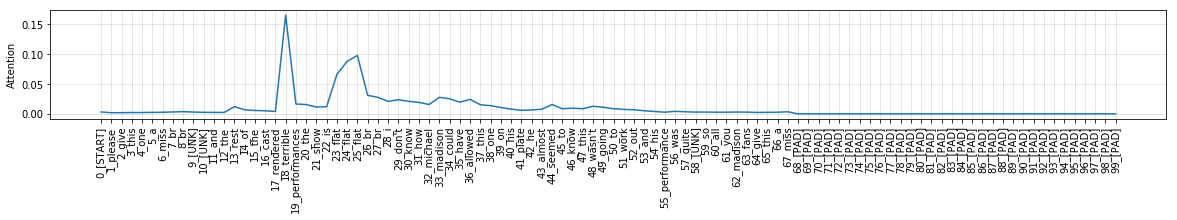

<span style="padding:2px;">[actual:   positive >< pred:   positive]</span>  <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[START]</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(227, 227, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(180, 180, 255, 0.6); color:#000; padding:2px; font-weight='bold'">requires</span> <span style="background: rgba(199, 199, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(139, 139, 255, 0.6); color:#000; padding:2px; font-weight='bold'">lot</span> <span style="background: rgba(193, 193, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(167, 167, 255, 0.6); color:#000; padding:2px; font-weight='bold'">patience</span> <span style="background: rgba(158, 158, 255, 0.6); color:#000; padding:2px; font-weight='bold'">because</span> <span style="background: rgba(204, 204, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(176, 176, 255, 0.6); color:#000; padding:2px; font-weight='bold'">focuses</span> <span style="background: rgba(198, 198, 255, 0.6); color:#000; padding:2px; font-weight='bold'">on</span> <span style="background: rgba(219, 219, 255, 0.6); color:#000; padding:2px; font-weight='bold'">mood</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(215, 215, 255, 0.6); color:#000; padding:2px; font-weight='bold'">character</span> <span style="background: rgba(202, 202, 255, 0.6); color:#000; padding:2px; font-weight='bold'">development</span> <span style="background: rgba(225, 225, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(174, 174, 255, 0.6); color:#000; padding:2px; font-weight='bold'">plot</span> <span style="background: rgba(188, 188, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(216, 216, 255, 0.6); color:#000; padding:2px; font-weight='bold'">very</span> <span style="background: rgba(32, 32, 255, 0.6); color:#000; padding:2px; font-weight='bold'">simple</span> <span style="background: rgba(125, 125, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(132, 132, 255, 0.6); color:#000; padding:2px; font-weight='bold'">many</span> <span style="background: rgba(162, 162, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(147, 147, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(195, 195, 255, 0.6); color:#000; padding:2px; font-weight='bold'">scenes</span> <span style="background: rgba(215, 215, 255, 0.6); color:#000; padding:2px; font-weight='bold'">take</span> <span style="background: rgba(228, 228, 255, 0.6); color:#000; padding:2px; font-weight='bold'">place</span> <span style="background: rgba(224, 224, 255, 0.6); color:#000; padding:2px; font-weight='bold'">on</span> <span style="background: rgba(224, 224, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">same</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">set</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">frances</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(233, 233, 255, 0.6); color:#000; padding:2px; font-weight='bold'">sandy</span> <span style="background: rgba(211, 211, 255, 0.6); color:#000; padding:2px; font-weight='bold'">dennis</span> <span style="background: rgba(202, 202, 255, 0.6); color:#000; padding:2px; font-weight='bold'">character</span> <span style="background: rgba(184, 184, 255, 0.6); color:#000; padding:2px; font-weight='bold'">apartment</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">but</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(227, 227, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(83, 83, 255, 0.6); color:#000; padding:2px; font-weight='bold'">builds</span> <span style="background: rgba(194, 194, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(176, 176, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(185, 185, 255, 0.6); color:#000; padding:2px; font-weight='bold'">disturbing</span> <span style="background: rgba(158, 158, 255, 0.6); color:#000; padding:2px; font-weight='bold'">climax</span> <span style="background: rgba(175, 175, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(176, 176, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(185, 185, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(160, 160, 255, 0.6); color:#000; padding:2px; font-weight='bold'">characters</span> <span style="background: rgba(213, 213, 255, 0.6); color:#000; padding:2px; font-weight='bold'">create</span> <span style="background: rgba(218, 218, 255, 0.6); color:#000; padding:2px; font-weight='bold'">an</span> <span style="background: rgba(181, 181, 255, 0.6); color:#000; padding:2px; font-weight='bold'">atmosphere</span> <span style="background: rgba(223, 223, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">with</span> <span style="background: rgba(209, 209, 255, 0.6); color:#000; padding:2px; font-weight='bold'">sexual</span> <span style="background: rgba(210, 210, 255, 0.6); color:#000; padding:2px; font-weight='bold'">tension</span> <span style="background: rgba(195, 195, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">psychological</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(220, 220, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it's</span> <span style="background: rgba(190, 190, 255, 0.6); color:#000; padding:2px; font-weight='bold'">very</span> <span style="background: rgba(201, 201, 255, 0.6); color:#000; padding:2px; font-weight='bold'">interesting</span> <span style="background: rgba(224, 224, 255, 0.6); color:#000; padding:2px; font-weight='bold'">that</span> <span style="background: rgba(219, 219, 255, 0.6); color:#000; padding:2px; font-weight='bold'">robert</span> <span style="background: rgba(221, 221, 255, 0.6); color:#000; padding:2px; font-weight='bold'">altman</span> <span style="background: rgba(214, 214, 255, 0.6); color:#000; padding:2px; font-weight='bold'">directed</span> <span style="background: rgba(217, 217, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(198, 198, 255, 0.6); color:#000; padding:2px; font-weight='bold'">considering</span> <span style="background: rgba(217, 217, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(217, 217, 255, 0.6); color:#000; padding:2px; font-weight='bold'">style</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(131, 131, 255, 0.6); color:#000; padding:2px; font-weight='bold'">structure</span> <span style="background: rgba(175, 175, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(215, 215, 255, 0.6); color:#000; padding:2px; font-weight='bold'">his</span> <span style="background: rgba(227, 227, 255, 0.6); color:#000; padding:2px; font-weight='bold'">other</span> <span style="background: rgba(204, 204, 255, 0.6); color:#000; padding:2px; font-weight='bold'">films</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">still</span> <span style="background: rgba(233, 233, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(225, 225, 255, 0.6); color:#000; padding:2px; font-weight='bold'">trademark</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">altman</span> <span style="background: rgba(177, 177, 255, 0.6); color:#000; padding:2px; font-weight='bold'">audio</span> <span style="background: rgba(216, 216, 255, 0.6); color:#000; padding:2px; font-weight='bold'">style</span> <span style="background: rgba(196, 196, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(0, 0, 255, 0.6); color:#000; padding:2px; font-weight='bold'">evident</span> <span style="background: rgba(217, 217, 255, 0.6); color:#000; padding:2px; font-weight='bold'">here</span> <span style="background: rgba(164, 164, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(185, 185, 255, 0.6); color:#000; padding:2px; font-weight='bold'">there</span> <span style="background: rgba(186, 186, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(137, 137, 255, 0.6); color:#000; padding:2px; font-weight='bold'">think</span> <span style="background: rgba(172, 172, 255, 0.6); color:#000; padding:2px; font-weight='bold'">what</span> <span style="background: rgba(160, 160, 255, 0.6); color:#000; padding:2px; font-weight='bold'">really</span> <span style="background: rgba(121, 121, 255, 0.6); color:#000; padding:2px; font-weight='bold'">makes</span> <span style="background: rgba(165, 165, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(145, 145, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(146, 146, 255, 0.6); color:#000; padding:2px; font-weight='bold'">work</span> <span style="background: rgba(138, 138, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(137, 137, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span>

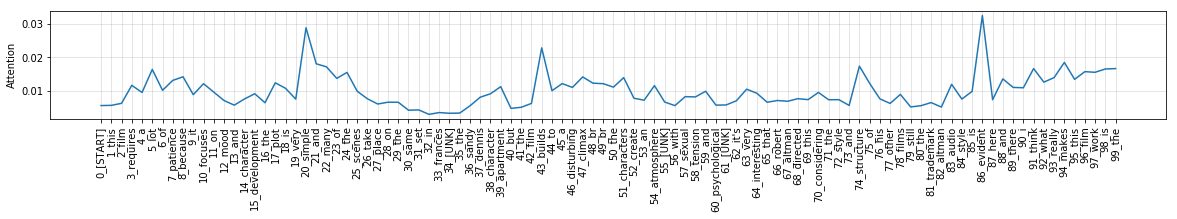

<span style="padding:2px;">[actual:   positive >< pred:   positive]</span>  <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[START]</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">many</span> <span style="background: rgba(233, 233, 255, 0.6); color:#000; padding:2px; font-weight='bold'">animation</span> <span style="background: rgba(133, 133, 255, 0.6); color:#000; padding:2px; font-weight='bold'">buffs</span> <span style="background: rgba(223, 223, 255, 0.6); color:#000; padding:2px; font-weight='bold'">consider</span> <span style="background: rgba(228, 228, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(227, 227, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(0, 0, 255, 0.6); color:#000; padding:2px; font-weight='bold'">great</span> <span style="background: rgba(151, 151, 255, 0.6); color:#000; padding:2px; font-weight='bold'">forgotten</span> <span style="background: rgba(7, 7, 255, 0.6); color:#000; padding:2px; font-weight='bold'">genius</span> <span style="background: rgba(192, 192, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(200, 200, 255, 0.6); color:#000; padding:2px; font-weight='bold'">one</span> <span style="background: rgba(209, 209, 255, 0.6); color:#000; padding:2px; font-weight='bold'">special</span> <span style="background: rgba(213, 213, 255, 0.6); color:#000; padding:2px; font-weight='bold'">branch</span> <span style="background: rgba(218, 218, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(209, 209, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(212, 212, 255, 0.6); color:#000; padding:2px; font-weight='bold'">art</span> <span style="background: rgba(106, 106, 255, 0.6); color:#000; padding:2px; font-weight='bold'">puppet</span> <span style="background: rgba(111, 111, 255, 0.6); color:#000; padding:2px; font-weight='bold'">animation</span> <span style="background: rgba(188, 188, 255, 0.6); color:#000; padding:2px; font-weight='bold'">which</span> <span style="background: rgba(180, 180, 255, 0.6); color:#000; padding:2px; font-weight='bold'">he</span> <span style="background: rgba(233, 233, 255, 0.6); color:#000; padding:2px; font-weight='bold'">invented</span> <span style="background: rgba(197, 197, 255, 0.6); color:#000; padding:2px; font-weight='bold'">almost</span> <span style="background: rgba(230, 230, 255, 0.6); color:#000; padding:2px; font-weight='bold'">single</span> <span style="background: rgba(228, 228, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(230, 230, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">as</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">happened</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">almost</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">accidentally</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">as</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">young</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">man</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">more</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">interested</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">than</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">cinema</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">but</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">his</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">attempt</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">two</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">fighting</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">led</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">an</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">unexpected</span> <span style="background: rgba(162, 162, 255, 0.6); color:#000; padding:2px; font-weight='bold'">breakthrough</span> <span style="background: rgba(227, 227, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span> <span style="background: rgba(220, 220, 255, 0.6); color:#000; padding:2px; font-weight='bold'">film</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">making</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">when</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">he</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">realized</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">he</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">could</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">movement</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">by</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">beetle</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">them</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">one</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">frame</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">at</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">time</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(163, 163, 255, 0.6); color:#000; padding:2px; font-weight='bold'">discovery</span> <span style="background: rgba(221, 221, 255, 0.6); color:#000; padding:2px; font-weight='bold'">led</span> <span style="background: rgba(229, 229, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(222, 222, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(221, 221, 255, 0.6); color:#000; padding:2px; font-weight='bold'">production</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(216, 216, 255, 0.6); color:#000; padding:2px; font-weight='bold'">amazingly</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">elaborate</span> <span style="background: rgba(221, 221, 255, 0.6); color:#000; padding:2px; font-weight='bold'">classic</span> <span style="background: rgba(221, 221, 255, 0.6); color:#000; padding:2px; font-weight='bold'">short</span> <span style="background: rgba(228, 228, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">revenge</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">which</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">he</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">made</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span>

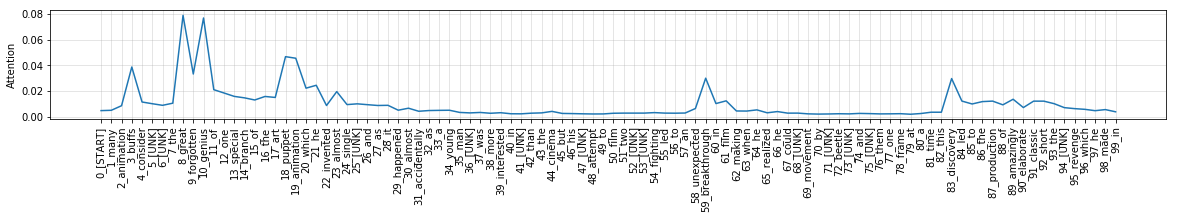

<span style="padding:2px;">[actual:   negative >< pred:   negative]</span>  <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[START]</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">generally</span> <span style="background: rgba(224, 224, 255, 0.6); color:#000; padding:2px; font-weight='bold'">love</span> <span style="background: rgba(235, 235, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(219, 219, 255, 0.6); color:#000; padding:2px; font-weight='bold'">type</span> <span style="background: rgba(233, 233, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">movie</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">however</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">time</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">found</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">myself</span> <span style="background: rgba(233, 233, 255, 0.6); color:#000; padding:2px; font-weight='bold'">wanting</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(194, 194, 255, 0.6); color:#000; padding:2px; font-weight='bold'">kick</span> <span style="background: rgba(216, 216, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">screen</span> <span style="background: rgba(177, 177, 255, 0.6); color:#000; padding:2px; font-weight='bold'">since</span> <span style="background: rgba(208, 208, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">can't</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">do</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">that</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">will</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">just</span> <span style="background: rgba(193, 193, 255, 0.6); color:#000; padding:2px; font-weight='bold'">complain</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">about</span> <span style="background: rgba(220, 220, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(226, 226, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">was</span> <span style="background: rgba(233, 233, 255, 0.6); color:#000; padding:2px; font-weight='bold'">absolutely</span> <span style="background: rgba(116, 116, 255, 0.6); color:#000; padding:2px; font-weight='bold'">idiotic</span> <span style="background: rgba(194, 194, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(205, 205, 255, 0.6); color:#000; padding:2px; font-weight='bold'">things</span> <span style="background: rgba(212, 212, 255, 0.6); color:#000; padding:2px; font-weight='bold'">that</span> <span style="background: rgba(228, 228, 255, 0.6); color:#000; padding:2px; font-weight='bold'">happen</span> <span style="background: rgba(226, 226, 255, 0.6); color:#000; padding:2px; font-weight='bold'">with</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">dead</span> <span style="background: rgba(214, 214, 255, 0.6); color:#000; padding:2px; font-weight='bold'">kids</span> <span style="background: rgba(221, 221, 255, 0.6); color:#000; padding:2px; font-weight='bold'">are</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">very</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">cool</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">but</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">alive</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">people</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">are</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">absolute</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">idiots</span> <span style="background: rgba(234, 234, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(192, 192, 255, 0.6); color:#000; padding:2px; font-weight='bold'">am</span> <span style="background: rgba(211, 211, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(185, 185, 255, 0.6); color:#000; padding:2px; font-weight='bold'">grown</span> <span style="background: rgba(219, 219, 255, 0.6); color:#000; padding:2px; font-weight='bold'">man</span> <span style="background: rgba(165, 165, 255, 0.6); color:#000; padding:2px; font-weight='bold'">pretty</span> <span style="background: rgba(205, 205, 255, 0.6); color:#000; padding:2px; font-weight='bold'">big</span> <span style="background: rgba(223, 223, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(214, 214, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(224, 224, 255, 0.6); color:#000; padding:2px; font-weight='bold'">can</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">defend</span> <span style="background: rgba(226, 226, 255, 0.6); color:#000; padding:2px; font-weight='bold'">myself</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">well</span> <span style="background: rgba(223, 223, 255, 0.6); color:#000; padding:2px; font-weight='bold'">however</span> <span style="background: rgba(234, 234, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(214, 214, 255, 0.6); color:#000; padding:2px; font-weight='bold'">would</span> <span style="background: rgba(212, 212, 255, 0.6); color:#000; padding:2px; font-weight='bold'">not</span> <span style="background: rgba(198, 198, 255, 0.6); color:#000; padding:2px; font-weight='bold'">do</span> <span style="background: rgba(49, 49, 255, 0.6); color:#000; padding:2px; font-weight='bold'">half</span> <span style="background: rgba(186, 186, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(0, 0, 255, 0.6); color:#000; padding:2px; font-weight='bold'">stuff</span> <span style="background: rgba(168, 168, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(169, 169, 255, 0.6); color:#000; padding:2px; font-weight='bold'">little</span> <span style="background: rgba(134, 134, 255, 0.6); color:#000; padding:2px; font-weight='bold'">girl</span> <span style="background: rgba(148, 148, 255, 0.6); color:#000; padding:2px; font-weight='bold'">does</span> <span style="background: rgba(188, 188, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span> <span style="background: rgba(186, 186, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(181, 181, 255, 0.6); color:#000; padding:2px; font-weight='bold'">movie</span> <span style="background: rgba(224, 224, 255, 0.6); color:#000; padding:2px; font-weight='bold'">also</span> <span style="background: rgba(213, 213, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(10, 10, 255, 0.6); color:#000; padding:2px; font-weight='bold'">mother</span> <span style="background: rgba(188, 188, 255, 0.6); color:#000; padding:2px; font-weight='bold'">in</span> <span style="background: rgba(187, 187, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(183, 183, 255, 0.6); color:#000; padding:2px; font-weight='bold'">movie</span> <span style="background: rgba(191, 191, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(146, 146, 255, 0.6); color:#000; padding:2px; font-weight='bold'">reckless</span> <span style="background: rgba(191, 191, 255, 0.6); color:#000; padding:2px; font-weight='bold'">with</span> <span style="background: rgba(202, 202, 255, 0.6); color:#000; padding:2px; font-weight='bold'">her</span> <span style="background: rgba(210, 210, 255, 0.6); color:#000; padding:2px; font-weight='bold'">children</span> <span style="background: rgba(212, 212, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(221, 221, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(171, 171, 255, 0.6); color:#000; padding:2px; font-weight='bold'">point</span> <span style="background: rgba(198, 198, 255, 0.6); color:#000; padding:2px; font-weight='bold'">of</span> <span style="background: rgba(162, 162, 255, 0.6); color:#000; padding:2px; font-weight='bold'">neglect</span> <span style="background: rgba(197, 197, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(194, 194, 255, 0.6); color:#000; padding:2px; font-weight='bold'">wish</span> <span style="background: rgba(197, 197, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(159, 159, 255, 0.6); color:#000; padding:2px; font-weight='bold'">wasn't</span>

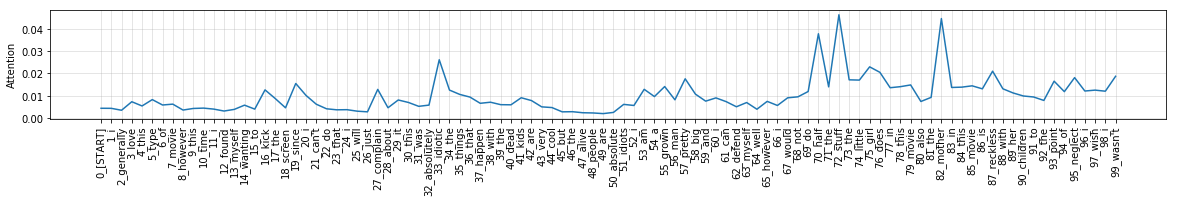

<span style="padding:2px;">[actual:   positive >< pred:   negative]</span>  <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[START]</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">like</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">some</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">other</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">people</span> <span style="background: rgba(255, 255, 255, 0.6); color:#000; padding:2px; font-weight='bold'">wrote</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i'm</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">a</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">die</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">hard</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">mario</span> <span style="background: rgba(248, 248, 255, 0.6); color:#000; padding:2px; font-weight='bold'">fan</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(227, 227, 255, 0.6); color:#000; padding:2px; font-weight='bold'">loved</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">game</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">game</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">starts</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">slightly</span> <span style="background: rgba(115, 115, 255, 0.6); color:#000; padding:2px; font-weight='bold'">boring</span> <span style="background: rgba(235, 235, 255, 0.6); color:#000; padding:2px; font-weight='bold'">but</span> <span style="background: rgba(235, 235, 255, 0.6); color:#000; padding:2px; font-weight='bold'">trust</span> <span style="background: rgba(240, 240, 255, 0.6); color:#000; padding:2px; font-weight='bold'">me</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it's</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">worth</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(244, 244, 255, 0.6); color:#000; padding:2px; font-weight='bold'">as</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">soon</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">as</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">you</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">start</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">your</span> <span style="background: rgba(197, 197, 255, 0.6); color:#000; padding:2px; font-weight='bold'">hooked</span> <span style="background: rgba(234, 234, 255, 0.6); color:#000; padding:2px; font-weight='bold'">the</span> <span style="background: rgba(225, 225, 255, 0.6); color:#000; padding:2px; font-weight='bold'">levels</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">are</span> <span style="background: rgba(0, 0, 255, 0.6); color:#000; padding:2px; font-weight='bold'">fun</span> <span style="background: rgba(200, 200, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(224, 224, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">they</span> <span style="background: rgba(224, 224, 255, 0.6); color:#000; padding:2px; font-weight='bold'">will</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">hook</span> <span style="background: rgba(219, 219, 255, 0.6); color:#000; padding:2px; font-weight='bold'">you</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">your</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">mind</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">turns</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(253, 253, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i'm</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">not</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">kidding</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(242, 242, 255, 0.6); color:#000; padding:2px; font-weight='bold'">game</span> <span style="background: rgba(241, 241, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">also</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">[UNK]</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">and</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">is</span> <span style="background: rgba(229, 229, 255, 0.6); color:#000; padding:2px; font-weight='bold'">beautifully</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">done</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">keep</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">spoiler</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">free</span> <span style="background: rgba(249, 249, 255, 0.6); color:#000; padding:2px; font-weight='bold'">i</span> <span style="background: rgba(245, 245, 255, 0.6); color:#000; padding:2px; font-weight='bold'">have</span> <span style="background: rgba(247, 247, 255, 0.6); color:#000; padding:2px; font-weight='bold'">to</span> <span style="background: rgba(252, 252, 255, 0.6); color:#000; padding:2px; font-weight='bold'">keep</span> <span style="background: rgba(254, 254, 255, 0.6); color:#000; padding:2px; font-weight='bold'">my</span> <span style="background: rgba(17, 17, 255, 0.6); color:#000; padding:2px; font-weight='bold'">mouth</span> <span style="background: rgba(217, 217, 255, 0.6); color:#000; padding:2px; font-weight='bold'">shut</span> <span style="background: rgba(220, 220, 255, 0.6); color:#000; padding:2px; font-weight='bold'">about</span> <span style="background: rgba(219, 219, 255, 0.6); color:#000; padding:2px; font-weight='bold'">details</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">but</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">please</span> <span style="background: rgba(217, 217, 255, 0.6); color:#000; padding:2px; font-weight='bold'">try</span> <span style="background: rgba(232, 232, 255, 0.6); color:#000; padding:2px; font-weight='bold'">this</span> <span style="background: rgba(231, 231, 255, 0.6); color:#000; padding:2px; font-weight='bold'">game</span> <span style="background: rgba(250, 250, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it'll</span> <span style="background: rgba(235, 235, 255, 0.6); color:#000; padding:2px; font-weight='bold'">be</span> <span style="background: rgba(237, 237, 255, 0.6); color:#000; padding:2px; font-weight='bold'">worth</span> <span style="background: rgba(246, 246, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it</span> <span style="background: rgba(239, 239, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(238, 238, 255, 0.6); color:#000; padding:2px; font-weight='bold'">br</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">story</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">9</span> <span style="background: rgba(234, 234, 255, 0.6); color:#000; padding:2px; font-weight='bold'">9</span> <span style="background: rgba(216, 216, 255, 0.6); color:#000; padding:2px; font-weight='bold'">action</span> <span style="background: rgba(216, 216, 255, 0.6); color:#000; padding:2px; font-weight='bold'">10</span> <span style="background: rgba(251, 251, 255, 0.6); color:#000; padding:2px; font-weight='bold'">1</span> <span style="background: rgba(236, 236, 255, 0.6); color:#000; padding:2px; font-weight='bold'">it's</span> <span style="background: rgba(243, 243, 255, 0.6); color:#000; padding:2px; font-weight='bold'">that</span>

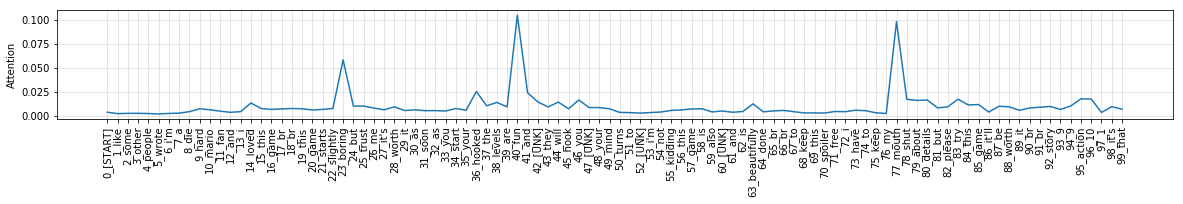

In [11]:
index2word = get_index2word()
index2label = {
    0: 'negative',
    1: 'positive'
}

for index in range(5):
    # reconstructing sample from word ids to actual words
    words = reconstruct(x_test[index], index2word)
    sample = x_test[index:index+1]

    # getting prediction and alphas
    pred = int(model.predict(sample)[0] >= 0.5)
    z = viz_model.predict(x_test[index:index+1])[0]
    
    # reescaling for visualization purposes
    w = (z - np.min(z)) / (np.max(z) - np.min(z))

    # ta-da
    print_sentence(index2label[y_test[index]], index2label[pred], words, w)
    plot_sentence(words, z)